## Sensitivity Analysis for Linear Regression Models
Sensitivity analysis helps us examine how sensitive a result is against the possibility of unobserved confounding. The current method only supports linear regression estimator. <br>
The partial R^2 of treatment with outcome shows how strongly confounders explaining all the residual outcome variation would have to be associated with the treatment to eliminate the estimated effect.<br>
The robustness value measures the minimum strength of association unobserved confounding should have with both treatment and outcome in order to change the conclusions.<br>
Robustness value close to 1 means the treatment effect can handle strong confounders explaining  almost all residual variation of the treatment and the outcome.<br>
Robustness value close to 0 means that even very weak confounders can also change the results.<br>
Benchmarking examines the sensitivity of causal inferences to plausible strengths of the omitted confounders.<br>
This method is based on https://carloscinelli.com/files/Cinelli%20and%20Hazlett%20(2020)%20-%20Making%20Sense%20of%20Sensitivity.pdf 

### Step 1: Load required packages

In [1]:
import os, sys
sys.path.append(os.path.abspath("../../../"))
import dowhy
from dowhy import CausalModel
import pandas as pd
import numpy as np
import dowhy.datasets 

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'ERROR',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning
#warnings.filterwarnings(action='ignore', category=DataConversionWarning)

### Step 2: Load the dataset 
We create a dataset with linear relationships between common causes and treatment, and common causes and outcome. Beta is the true causal effect.

In [2]:
np.random.seed(100) 
data = dowhy.datasets.linear_dataset( beta = 10,
                                      num_common_causes = 7,
                                      num_samples = 500,
                                      num_treatments = 1,
                                     stddev_treatment_noise =10,
                                     stddev_outcome_noise = 5
                                    )

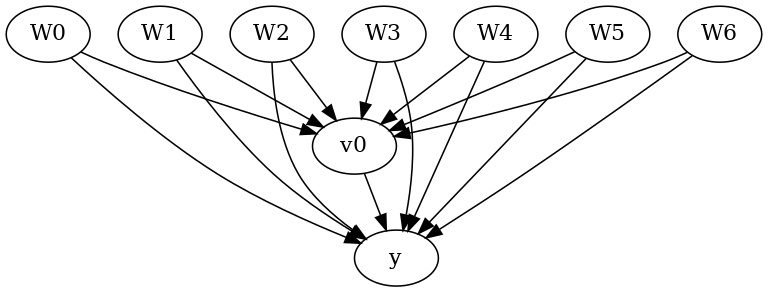

,W0,W1,W2,W3,W4,W5,W6,v0,y
0,-0.145062,-0.235286,0.784843,0.869131,-1.567724,-1.290234,0.116096,True,1.386517
1,-0.228109,-0.020264,-0.589792,0.188139,-2.649265,-1.764439,-0.167236,False,-16.159402
2,0.868298,-1.097642,-0.109792,0.487635,-1.861375,-0.527930,-0.066542,False,-0.702560
3,-0.017115,1.123918,0.346060,1.845425,0.848049,0.778865,0.596496,True,27.714465
4,-0.757347,-1.426205,-0.457063,1.528053,-2.681410,0.394312,-0.687839,False,-20.082633


In [3]:
model = CausalModel(
            data=data["df"],
            treatment=data["treatment_name"],
            outcome=data["outcome_name"],
            graph=data["gml_graph"],
            test_significance=None,
        )
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))
data['df'].head()

### Step 3: Create Causal Model
Remove one of the common causes to simulate unobserved confounding

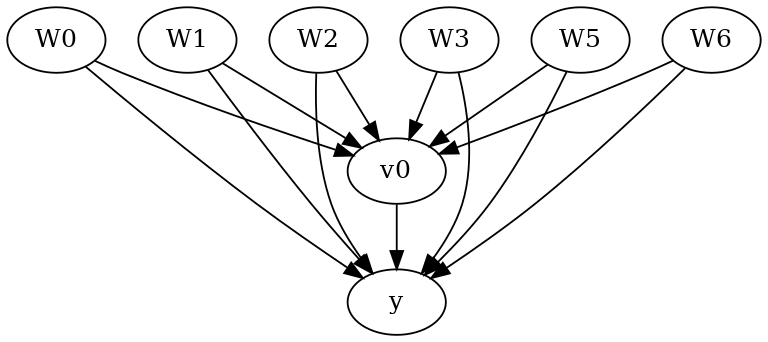

,W0,W1,W2,W3,W5,W6,v0,y
0,-0.145062,-0.235286,0.784843,0.869131,-1.290234,0.116096,True,1.386517
1,-0.228109,-0.020264,-0.589792,0.188139,-1.764439,-0.167236,False,-16.159402
2,0.868298,-1.097642,-0.109792,0.487635,-0.527930,-0.066542,False,-0.702560
3,-0.017115,1.123918,0.346060,1.845425,0.778865,0.596496,True,27.714465
4,-0.757347,-1.426205,-0.457063,1.528053,0.394312,-0.687839,False,-20.082633


In [4]:
data["df"] = data["df"].drop("W4", axis = 1)
graph_str = 'graph[directed 1node[ id "y" label "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"]  node[ id "W5" label "W5"] node[ id "W6" label "W6"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"] edge[ source "W3" target "v0"] edge[ source "W5" target "v0"] edge[ source "W6" target "v0"]edge[ source "W0" target "y"] edge[ source "W1" target "y"] edge[ source "W2" target "y"] edge[ source "W3" target "y"] edge[ source "W5" target "y"] edge[ source "W6" target "y"]]'
model = CausalModel(
            data=data["df"],
            treatment=data["treatment_name"],
            outcome=data["outcome_name"],
            graph=graph_str,
            test_significance=None,
        )
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))
data['df'].head()

### Step 4: Identification

In [5]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                          
─────(E[y|W1,W2,W5,W3,W6,W0])
d[v₀]                        
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W5,W3,W6,W0,U) = P(y|v0,W1,W2,W5,W3,W6,W0)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Step 5: Estimation
Currently only Linear Regression estimator is supported for Linear Sensitivity Analysis

In [6]:
estimate = model.estimate_effect(identified_estimand,method_name="backdoor.linear_regression")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                          
─────(E[y|W1,W2,W5,W3,W6,W0])
d[v₀]                        
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W5,W3,W6,W0,U) = P(y|v0,W1,W2,W5,W3,W6,W0)

## Realized estimand
b: y~v0+W1+W2+W5+W3+W6+W0
Target units: ate

## Estimate
Mean value: 10.697677486880918



### Step 6: Refutation and Sensitivity Analysis
<b>identified_estimand</b>: An instance of the identifiedEstimand class that provides the information with respect to which causal pathways are employed when the treatment effects the outcome<br>
<b>estimate</b>: An instance of CausalEstimate class. The estimate obtained from the estimator for the original data.<br>
<b>method_name</b>: Refutation method name <br>
<b>simulated_method_name</b>: "linear-partial-R2" for Linear Sensitivity Analysis<br>
<b>benchmark_common_causes</b>: Name of the covariates used to bound the strengths of unobserved confounder<br>
<b>percent_change_estimate</b>: It is the percentage of reduction of treatment estimate that could alter the results (default = 1) if percent_change_estimate = 1, the robustness value describes the strength of association of confounders with treatment and outcome in order to reduce the estimate by 100% i.e bring it down to 0. <br>
<b>confounder_increases_estimate</b>: confounder_increases_estimate = True implies that confounder increases the absolute value of estimate and vice versa. Default is confounder_increases_estimate = False i.e. the considered confounders pull estimate towards zero<br>
<b>effect_fraction_on_treatment</b>: Strength of association between unobserved confounder and treatment compared to benchmark covariate<br>
<b>effect_fraction_on_outcome</b>: Strength of association between unobserved confounder and outcome compared to benchmark covariate<br>
<b>null_hypothesis_effect</b>: assumed effect under the null hypothesis (default = 0) <br>
<b>plot_estimate</b>: Generate contour plot for estimate while performing sensitivity analysis. (default = True). 
                              To override the setting, set plot_estimate = False.

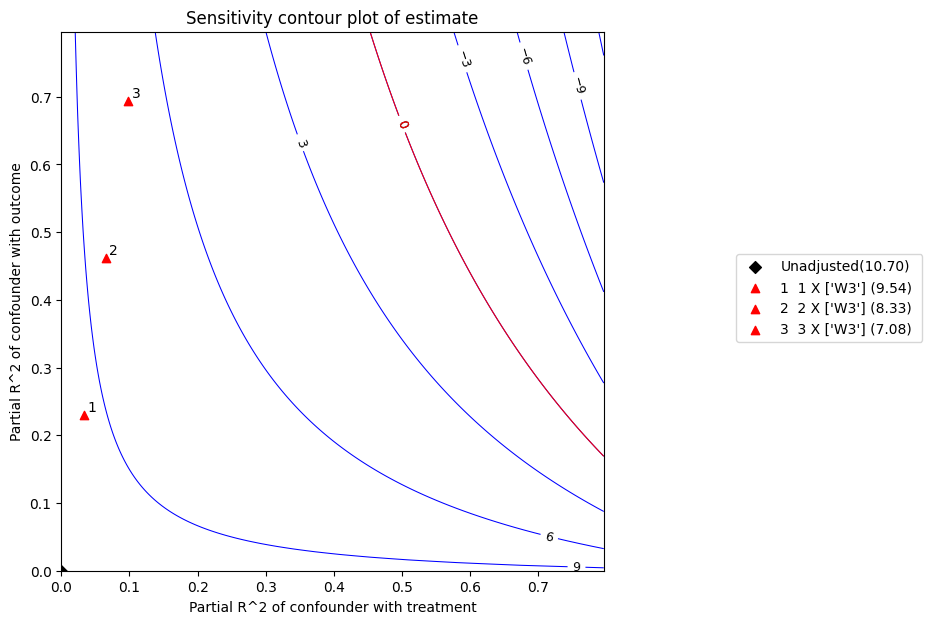

In [7]:
refute = model.refute_estimate(identified_estimand, estimate ,
                               method_name = "add_unobserved_common_cause",
                               simulated_method_name = "linear-partial-R2", 
                               benchmark_common_causes = ["W3"],
                               effect_fraction_on_treatment = [ 1,2,3]
                              )

The x axis shows hypothetical partial R2 values of unobserved confounder(s) with the treatment. The y axis shows hypothetical partial R2 of unobserved confounder(s) with the outcome.<br>
The contour levels represent adjusted t-values or estimates for unobserved confounders with hypothetical partialR2 values when these would be included in full regression model. <br>
The red line is the critical threshold: confounders with such strength or stronger are sufficient to invalidate the research conclusions.

In [8]:
refute.stats

{'estimate': 10.697677486880917,
 'standard_error': 0.5938735661282948,
 'degree of freedom': 492,
 't_statistic': 18.013392238727615,
 'r2yt_w': 0.39741498372666795,
 'partial_f2': 0.6595168698094559,
 'robustness_value': 0.5467445572181008,
 'robustness_value_alpha': 0.5076289101030925}

In [9]:
refute.benchmarking_results

,r2tu_w,r2yu_tw,bias_adjusted_estimate,bias_adjusted_se,bias_adjusted_t,bias_adjusted_lower_CI,bias_adjusted_upper_CI
0,0.032677,0.230238,9.535964,0.530308,17.981928,8.494016,10.577912
1,0.065354,0.461490,8.331381,0.451241,18.463243,7.444783,9.217979
2,0.098031,0.693855,7.080284,0.346341,20.443123,6.399795,7.760773


##### Parameter List for plot function
<b>plot_type</b>: "estimate" or "t-value" <br>
<b>critical_value</b>: special reference value of the estimate or t-value that will be highlighted in the plot<br>
<b>x_limit</b>: plot's maximum x_axis value (default = 0.8) <br>
<b>y_limit</b>: plot's minimum y_axis value (default = 0.8) <br>
<b>num_points_per_contour</b>: number of points to calculate and plot each contour line (default = 200) <br>
<b>plot_size</b>: tuple denoting the size of the plot (default = (7,7))<br>
<b>contours_color</b>: color of contour line (default = blue)<br>
                               String or array. If array, lines will be plotted with the specific color in ascending order.<br>
    <b>critical_contour_color</b>: color of threshold line (default = red)<br>
    <b>label_fontsize</b>: fontsize for labelling contours (default = 9)<br>
    <b>contour_linewidths</b>: linewidths for contours (default = 0.75)<br>
    <b>contour_linestyles</b>: linestyles for contours (default = "solid")
                                   See : https://matplotlib.org/3.5.0/gallery/lines_bars_and_markers/linestyles.html<br>
    <b>contours_label_color</b>: color of contour line label (default = black)<br>
    <b>critical_label_color</b>: color of threshold line label (default = red)<br>
    <b>unadjusted_estimate_marker</b>: marker type for unadjusted estimate in the plot (default = 'D')
                                           See: https://matplotlib.org/stable/api/markers_api.html <br><b>unadjusted_estimate_color</b>: marker color for unadjusted estimate in the plot (default = "black")<br>
    <b>adjusted_estimate_marker</b>: marker type for bias adjusted estimates in the plot (default = '^')<br><b>adjusted_estimate_color</b>: marker color for bias adjusted estimates in the plot (default = "red")<br>
    <b>legend_position</b>:tuple denoting the position of the legend (default = (1.6, 0.6))<br>

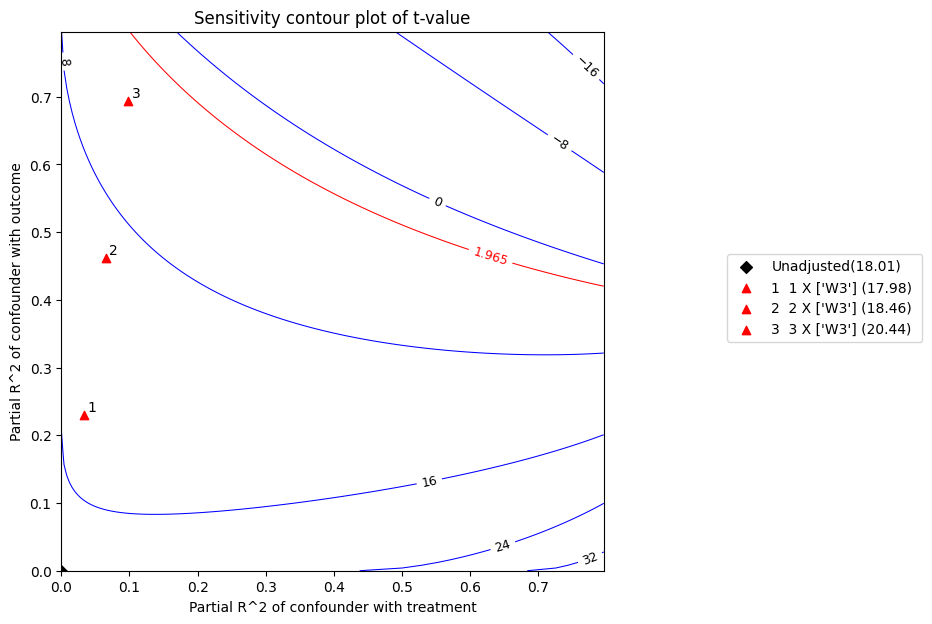

In [10]:
refute.plot(plot_type = 't-value')

The t statistic is the coefficient divided by its standard error. The higher the t-value, the greater the evidence to reject the null hypothesis. <br>
According to the above plot,at 5% significance level, the null hypothesis of zero effect would be rejected given the above confounders. 

In [11]:
print(refute)

Sensitivity Analysis to Unobserved Confounding using R^2 paramterization

Unadjusted Estimates of Treatment ['v0'] :
Coefficient Estimate : 10.697677486880917
Degree of Freedom : 492
Standard Error : 0.5938735661282948
t-value : 18.013392238727615
F^2 value : 0.6595168698094559

Sensitivity Statistics : 
Partial R2 of treatment with outcome : 0.39741498372666795
Robustness Value : 0.5467445572181008

Interpretation of results :
Any confounder explaining less than 54.67% percent of the residual variance of both the treatment and the outcome would not be strong enough to explain away the observed effect i.e bring down the estimate to 0 

For a significance level of 5.0%, any confounder explaining more than 50.76% percent of the residual variance of both the treatment and the outcome would be strong enough to make the estimated effect not 'statistically significant'

If confounders explained 100% of the residual variance of the outcome, they would need to explain at least 39.74% of the re

#### Sensitivity Analysis for dataset with no confounders
We now run the sensitivity analysis for the same dataset but without dropping any variable. <br>
We get a robustness value goes from 0.55 to 0.95 which means that treatment effect can handle strong confounders explaining  almost all residual variation of the treatment and the outcome. <br>

In [12]:
np.random.seed(100) 
data = dowhy.datasets.linear_dataset( beta = 10,
                                      num_common_causes = 7,
                                      num_samples = 500,
                                      num_treatments = 1,
                                     stddev_treatment_noise=10,
                                     stddev_outcome_noise = 1
                                    )

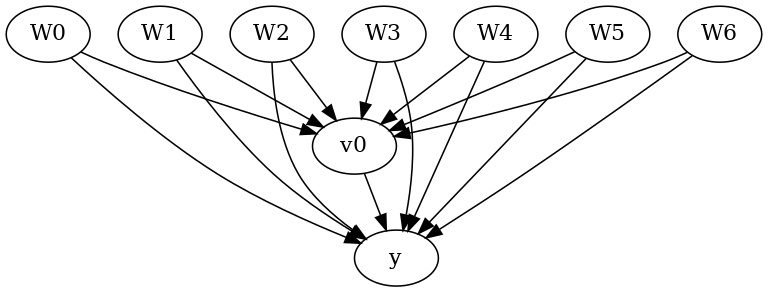

,W0,W1,W2,W3,W4,W5,W6,v0,y
0,-0.145062,-0.235286,0.784843,0.869131,-1.567724,-1.290234,0.116096,True,6.311809
1,-0.228109,-0.020264,-0.589792,0.188139,-2.649265,-1.764439,-0.167236,False,-12.274406
2,0.868298,-1.097642,-0.109792,0.487635,-1.861375,-0.527930,-0.066542,False,-6.487561
3,-0.017115,1.123918,0.346060,1.845425,0.848049,0.778865,0.596496,True,24.653183
4,-0.757347,-1.426205,-0.457063,1.528053,-2.681410,0.394312,-0.687839,False,-13.770396


In [13]:
model = CausalModel(
            data=data["df"],
            treatment=data["treatment_name"],
            outcome=data["outcome_name"],
            graph=data["gml_graph"],
            test_significance=None,
        )
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))
data['df'].head()

In [14]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                             
─────(E[y|W1,W2,W5,W4,W3,W6,W0])
d[v₀]                           
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W5,W4,W3,W6,W0,U) = P(y|v0,W1,W2,W5,W4,W3,W6,W0)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [15]:
estimate = model.estimate_effect(identified_estimand,method_name="backdoor.linear_regression")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                             
─────(E[y|W1,W2,W5,W4,W3,W6,W0])
d[v₀]                           
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W5,W4,W3,W6,W0,U) = P(y|v0,W1,W2,W5,W4,W3,W6,W0)

## Realized estimand
b: y~v0+W1+W2+W5+W4+W3+W6+W0
Target units: ate

## Estimate
Mean value: 10.081924375588311



/__w/dowhy/dowhy/dowhy/causal_refuters/linear_sensitivity_analyzer.py:200: RuntimeWarning: divide by zero encountered in divide
  bias_adjusted_t = (bias_adjusted_estimate - self.null_hypothesis_effect) / bias_adjusted_se
/__w/dowhy/dowhy/dowhy/causal_refuters/linear_sensitivity_analyzer.py:202: RuntimeWarning: invalid value encountered in divide
  bias_adjusted_partial_r2 = bias_adjusted_t**2 / (


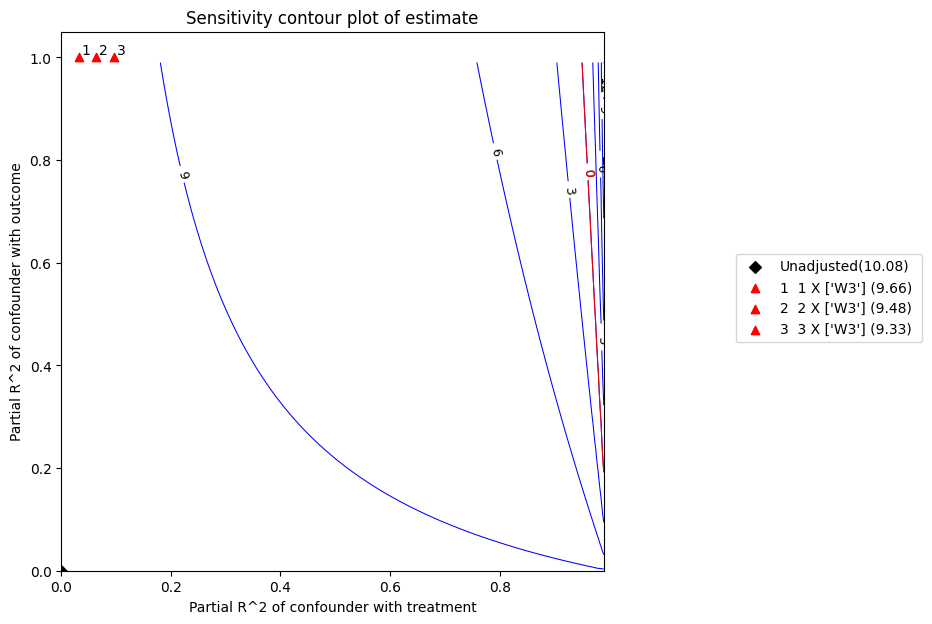

In [16]:
refute = model.refute_estimate(identified_estimand, estimate ,
                               method_name = "add_unobserved_common_cause",
                               simulated_method_name = "linear-partial-R2", 
                               benchmark_common_causes = ["W3"],
                               effect_fraction_on_treatment = [ 1,2,3])

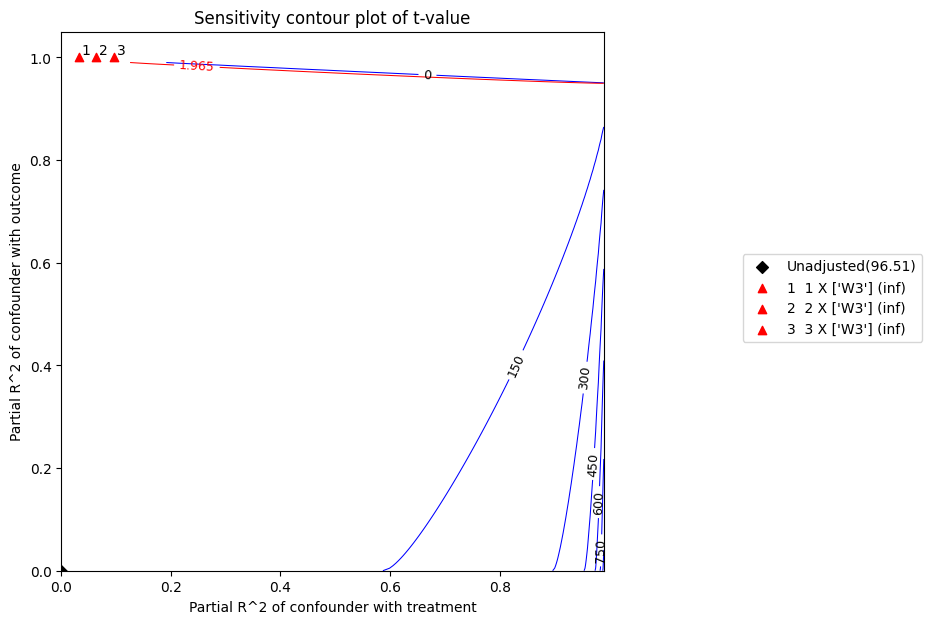

In [17]:
refute.plot(plot_type = 't-value')

In [18]:
print(refute)

Sensitivity Analysis to Unobserved Confounding using R^2 paramterization

Unadjusted Estimates of Treatment ['v0'] :
Coefficient Estimate : 10.081924375588311
Degree of Freedom : 491
Standard Error : 0.10446229543424758
t-value : 96.51256784735547
F^2 value : 18.970826379817503

Sensitivity Statistics : 
Partial R2 of treatment with outcome : 0.9499269594066173
Robustness Value : 0.9522057801012398

Interpretation of results :
Any confounder explaining less than 95.22% percent of the residual variance of both the treatment and the outcome would not be strong enough to explain away the observed effect i.e bring down the estimate to 0 

For a significance level of 5.0%, any confounder explaining more than 95.04% percent of the residual variance of both the treatment and the outcome would be strong enough to make the estimated effect not 'statistically significant'

If confounders explained 100% of the residual variance of the outcome, they would need to explain at least 94.99% of the res

In [19]:
refute.stats

{'estimate': 10.081924375588311,
 'standard_error': 0.10446229543424758,
 'degree of freedom': 491,
 't_statistic': 96.51256784735547,
 'r2yt_w': 0.9499269594066173,
 'partial_f2': 18.970826379817503,
 'robustness_value': 0.9522057801012398,
 'robustness_value_alpha': 0.950386691319526}

In [20]:
refute.benchmarking_results

,r2tu_w,r2yu_tw,bias_adjusted_estimate,bias_adjusted_se,bias_adjusted_t,bias_adjusted_lower_CI,bias_adjusted_upper_CI
0,0.031976,1.0,9.661229,0.0,inf,9.661229,9.661229
1,0.063952,1.0,9.476895,0.0,inf,9.476895,9.476895
2,0.095927,1.0,9.327927,0.0,inf,9.327927,9.327927
